# The scaled outer Solar System

In this example we will be studying a rescaled version of the outer Solar System in which the masses of the 4 giant planets (Jupiter, Saturn, Uranus and Neptune) have been increased by a factor of 50. It is [well known](https://iopscience.iop.org/article/10.1086/300541/meta) that such a configuration is dynamically unstable: in the short term the planets undergo close encounters which eventually lead to the expulsion of one or more planets from the Solar System. We will use this setup to illustrate a creative way of exploiting heyoka.py's event detection system.

We begin with the definition of the system's parameters and initial conditions (taken from the [Brouwer's law example](<./Outer Solar System.ipynb>)):

In [1]:
# Blowup factor.
bfac = 50

# Masses: Sun, Jupiter, Saturn, Uranus, Neptune.
import numpy as np
masses = np.array([1.00000597682, bfac / 1047.355, bfac / 3501.6, bfac / 22869., bfac / 19314.])

# The gravitational constant.
G = 0.01720209895 * 0.01720209895 * 365 * 365

# Initial conditions.
ic = [# Sun.
      -4.06428567034226e-3, -6.08813756435987e-3, -1.66162304225834e-6, +6.69048890636161e-6 * 365,
      -6.33922479583593e-6 * 365, -3.13202145590767e-9 * 365,
      # Jupiter.
      +3.40546614227466e+0, +3.62978190075864e+0, +3.42386261766577e-2, -5.59797969310664e-3 * 365,
      +5.51815399480116e-3 * 365, -2.66711392865591e-6 * 365,
      # Saturn.
      +6.60801554403466e+0, +6.38084674585064e+0, -1.36145963724542e-1, -4.17354020307064e-3 * 365,
      +3.99723751748116e-3 * 365, +1.67206320571441e-5 * 365,
      # Uranus.
      +1.11636331405597e+1, +1.60373479057256e+1, +3.61783279369958e-1, -3.25884806151064e-3 * 365,
      +2.06438412905916e-3 * 365, -2.17699042180559e-5 * 365,
      # Neptune.
      -3.01777243405203e+1, +1.91155314998064e+0, -1.53887595621042e-1, -2.17471785045538e-4 * 365,
      -3.11361111025884e-3 * 365, +3.58344705491441e-5 * 365]

The units of measure are astronomical units, years and Solar masses.

Next, we proceed to the definition of the dynamics via the ``make_nbody_sys()`` helper:

In [2]:
import heyoka as hy

# Create the system of differential equations.
sys = hy.make_nbody_sys(5, masses = masses, Gconst = G)

In this setup we are expecting close encounters between the planets. In order to build a history of close encounters we will be tracking how the distance between pairs of planets evolves over time.

The square of the distance between planets $i$ and $j$ is

$$
D_{ij}\left( t \right) = \left[ x_i\left( t \right) - x_j\left( t \right) \right]^2 + \left[ y_i\left( t \right) - y_j\left( t \right) \right]^2 + \left[ z_i\left( t \right) - z_j\left( t \right) \right]^2,
$$

and its time derivative is

$$
\frac{dD_{ij}\left( t \right)}{dt} = 2\left[ x_i\left( t \right) - x_j\left( t \right) \right]\left[ v_{xi}\left( t \right) - v_{xj}\left( t \right) \right] +
2\left[ y_i\left( t \right) - y_j\left( t \right) \right]\left[ v_{yi}\left( t \right) - v_{yj}\left( t \right) \right] +
2\left[ z_i\left( t \right) - z_j\left( t \right) \right]\left[ v_{zi}\left( t \right) - v_{zj}\left( t \right) \right].
$$

$dD_{ij}\left( t \right)/dt$ is zero whenever the distance between planets $i$ and $j$ reaches a local minimum or maximum. By introducing the event equation

$$
\frac{dD_{ij}\left( t \right)}{dt} = 0
$$

in heyoka.py's [event detection](<./Event detection.ipynb>) system we will thus be able to track how the minima of the planetary distances evolve over time.

Let us begin with the definition of the event callback:

In [3]:
# List of minima for the mutual
# planetary distances.
ce_list = []

# The event callback.
class ce_cb:
    def __init__(self, i, j):
        self.i = i
        self.j = j
    def __call__(self, ta, time, d_sgn):
        # Compute the state of the system
        # at the point of minimum distance.
        # between planets i and j.
        ta.update_d_output(time)
        
        # Extract the position vectors
        # for planets i and j.
        st = ta.d_output.reshape(5, 6)
        ri = st[self.i, 0:3]
        rj = st[self.j, 0:3]

        # Append to ce_list:
        # - the time at which the minimum is reached,
        # - the indices of the planets,
        # - the distance between the planets.
        ce_list.append((time, self.i, self.j, np.linalg.norm(ri - rj)))

The event callback will log into the global variable ``ce_list`` various information about the state of the system when a distance minimum is detected.

Next, we can proceed to the definition of the events:

In [4]:
# The list of events.
evs = []

# Iterate over all the planet-planet pairs.
# NOTE: the planets have indices 1-4 in the ODE
# system, index 0 is the Sun.
for i in range(1, 5):
    xi, yi, zi = hy.make_vars("x_{}".format(i), "y_{}".format(i), "z_{}".format(i))
    vxi, vyi, vzi = hy.make_vars("vx_{}".format(i), "vy_{}".format(i), "vz_{}".format(i))

    for j in range(i + 1, 5):
        xj, yj, zj = hy.make_vars("x_{}".format(j), "y_{}".format(j), "z_{}".format(j))
        vxj, vyj, vzj = hy.make_vars("vx_{}".format(j), "vy_{}".format(j), "vz_{}".format(j))
        
        # The event equation.
        eq = (xi-xj)*(vxi-vxj) + (yi-yj)*(vyi-vyj) + (zi-zj)*(vzi-vzj)
        
        # Create the event and append it to
        # the event list.
        evs.append(hy.nt_event(eq, ce_cb(i, j), direction = hy.event_direction.positive))

Note how we specified a *positive* direction for the events. This means that the event is detected only when the value of ${dD_{ij}\left( t \right)}/{dt}$ switches from negative to positive (and not viceversa). In other words, by specifying a positive event direction we will be filtering out the maxima of $D_{ij}\left( t \right)$, retaining only the minima.

We are now ready to create the integrator object:

In [5]:
ta = hy.taylor_adaptive(sys, ic, high_accuracy = True, tol = 1e-18,
                        # The list of non-terminal events.
                        nt_events = evs)

Before proceeding with the integration, it is convenient the recentre the centre of mass in the origin with zero velocity, so that the bodies do not drift during the integration:

In [6]:
# Reshape for ease of indexing.
st = ta.state.reshape(5, 6)

# Compute the position of the COM.
com_x = np.sum(st[:, 0]*masses)/np.sum(masses)
com_y = np.sum(st[:, 1]*masses)/np.sum(masses)
com_z = np.sum(st[:, 2]*masses)/np.sum(masses)

# Compute the velocity of the COM.
com_vx = np.sum(st[:, 3]*masses)/np.sum(masses)
com_vy = np.sum(st[:, 4]*masses)/np.sum(masses)
com_vz = np.sum(st[:, 5]*masses)/np.sum(masses)

# Recentre.
st[:, 0] -= com_x
st[:, 1] -= com_y
st[:, 2] -= com_z
st[:, 3] -= com_vx
st[:, 4] -= com_vy
st[:, 5] -= com_vz

Let us proceed to the numerical integration:

In [7]:
# Integrate over a regular time grid
# up to 1000 years.
final_t = 1000.
t_grid = np.linspace(0, final_t, 1000)

# Integrate
_, _, _, _, out = ta.propagate_grid(t_grid)

We can now visualise the results. We will be plotting the evolution in time of the minima of the planet-planet distances:

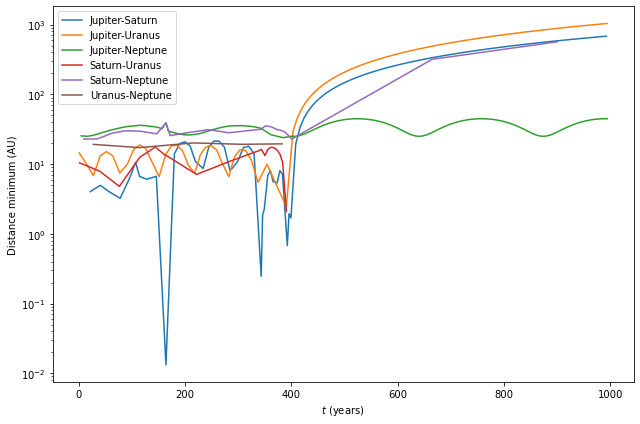

In [8]:
js_ce = list(filter(lambda t: t[1] == 1 and t[2] == 2, ce_list))
ju_ce = list(filter(lambda t: t[1] == 1 and t[2] == 3, ce_list))
jn_ce = list(filter(lambda t: t[1] == 1 and t[2] == 4, ce_list))

su_ce = list(filter(lambda t: t[1] == 2 and t[2] == 3, ce_list))
sn_ce = list(filter(lambda t: t[1] == 2 and t[2] == 4, ce_list))

un_ce = list(filter(lambda t: t[1] == 3 and t[2] == 4, ce_list))

%matplotlib inline
from matplotlib.pylab import plt
fig = plt.figure(figsize=(9, 6))
plt.yscale('log')

plt.plot([t[0] for t in js_ce], [t[3] for t in js_ce], label='Jupiter-Saturn')
plt.plot([t[0] for t in ju_ce], [t[3] for t in ju_ce], label='Jupiter-Uranus')
plt.plot([t[0] for t in jn_ce], [t[3] for t in jn_ce], label='Jupiter-Neptune')

plt.plot([t[0] for t in su_ce], [t[3] for t in su_ce], label='Saturn-Uranus')
plt.plot([t[0] for t in sn_ce], [t[3] for t in sn_ce], label='Saturn-Neptune')

plt.plot([t[0] for t in un_ce], [t[3] for t in un_ce], label='Uranus-Neptune')

plt.xlabel("$t$ (years)")
plt.ylabel("Distance minimum (AU)")

plt.legend()

plt.tight_layout()

The plot shows how Jupiter and Saturn undergo a few very close encounters (blue line). In particular, at $t\sim 160$, the distance minimum is $\sim 0.01\,\mathrm{AU}$ (less than 6 planetary radiuses, assuming that the inflated planets have the same density as the original ones). This is expected as Jupiter and Saturn are the most massive planets and they occupy adjacent orbits.

Eventually, Saturn and Uranus are ejected from the Solar System, while Neptune remains bound to the Sun with an orbit strongly perturbed by Jupiter. This can be seen by the green line, representing the minimum Jupiter-Neptune distance, which fluctuates periodically.

Note how for some planetary pairs (i.e., brown and red) the lines end before $t=1000$. This means that the distance between the planets keeps on growing without ever reaching again a stationary point. For other pairs (e.g., orange and blue), local stationary points remain even after one of the planets in the pair is ejected. This means the orbital velocity of the bound planet is greater than the escape velocity of the unbound planet, and as such the mutual distance, while overall increasing over time, temporarily decreases when the bound planet momentarily "catches up" with the escaped planet.

We are now going to take a look at the evolution of the Heliocentric orbital elements of the planets over time. Let us begin with the semi-major axis first. We will be using [pykep](https://esa.github.io/pykep/) for the conversion between Cartesian coordinates and Keplerian elements:

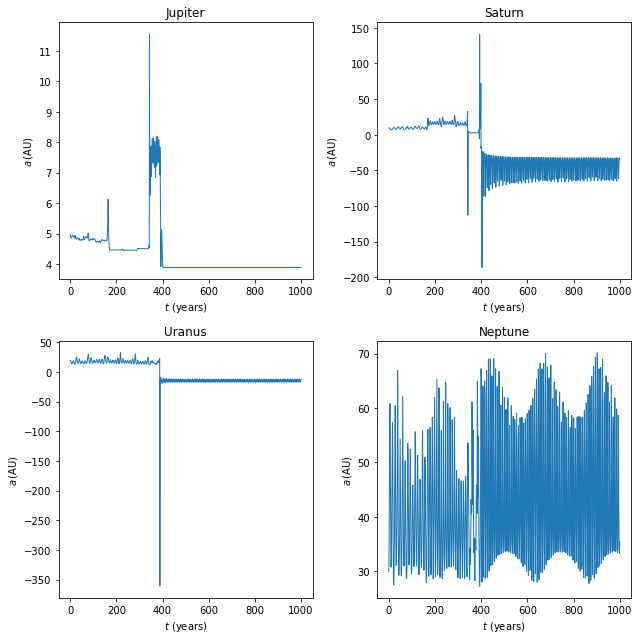

In [9]:
# Convert the planets' Cartesian states
# into sets of orbital elements.
def st2kep(state):
    import pykep as pk
    
    state = state.reshape(5, 6)
    
    out = []
    
    r0 = state[0, 0:3]
    v0 = state[0, 3:6]
    
    for i in range(1, 5):
        ri = state[i, 0:3]
        vi = state[i, 3:6]
        
        # NOTE: orbital elements computed
        # with respect to the Sun.
        r = ri - r0
        v = vi - v0
        
        mu = G*(masses[0] + masses[i])
        
        kep = list(pk.ic2par(r, v, mu))
        
        # NOTE: transform the Gudermannian into
        # hyperbolic semi-major axis for unbound
        # orbits.
        a = 1/(2/np.linalg.norm(r)-np.dot(v,v)/mu)
        kep[0] = a
        
        out.append(kep)
    
    return out

out_kep = np.array([st2kep(s) for s in out])

def plot_kep(idx, name):
    fig = plt.figure(figsize=(9,9))

    ax = fig.add_subplot(2, 2, 1)
    ax.plot(t_grid, out_kep[:, 0, idx], linewidth=1.)
    ax.set_xlabel("$t$ (years)")
    ax.set_ylabel(name)
    ax.set_title("Jupiter")

    ax = fig.add_subplot(2, 2, 2)
    ax.plot(t_grid, out_kep[:, 1, idx], linewidth=1.)
    ax.set_xlabel("$t$ (years)")
    ax.set_ylabel(name)
    ax.set_title("Saturn")

    ax = fig.add_subplot(2, 2, 3)
    ax.plot(t_grid, out_kep[:, 2, idx], linewidth=1.)
    ax.set_xlabel("$t$ (years)")
    ax.set_ylabel(name)
    ax.set_title("Uranus")

    ax = fig.add_subplot(2, 2, 4)
    ax.plot(t_grid, out_kep[:, 3, idx], linewidth=1.)
    ax.set_xlabel("$t$ (years)")
    ax.set_ylabel(name)
    ax.set_title("Neptune")

    plt.tight_layout()

plot_kep(0, r"$a\,\left(\mathrm{AU}\right)$")

The plots indeed confirm that Saturn and Uranus are ejected (i.e., the semi-major axes become negative). After the ejection of Saturn and Uranus, Jupiter settles in a stable quasi-Keplerian orbit, while Neptune ends up in an outer orbit perturbed by Jupiter. Note how the wide oscillations in semi-major axis for Neptune are due to the strong perturbation of Jupiter onto the Sun, which induces short-term oscillations in the Heliocentric orbital elements of the other planets.

Let us take a look at the eccentricities:

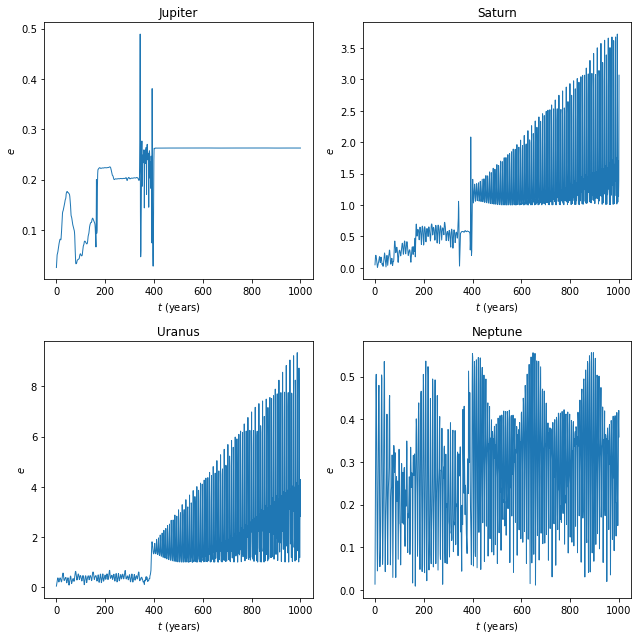

In [10]:
plot_kep(1, "$e$")

The eccentricities portray the same picture: after a turbulent and chaotic initial peroid, Saturn and Uranus are ejected ($e > 1$) and Jupiter settles into a medium-eccentricity quasi-Keplerian orbit. Like in the previous plot, the rapid variations in the eccentricities of Saturn, Uranus and Neptune for $t \gtrsim 400$ are due to the strong perturbation of Jupiter onto the Sun.

Let us now zoom into the first close encounter between Jupiter and Saturn at $t\sim 163$. First, we create a new integrator taking as initial conditions the state of the system at $t=163$ and disabling any form of event detection (as we do not need it any more):

In [11]:
ta_ce = hy.taylor_adaptive(sys, out[163], high_accuracy = True, tol = 1e-18)

Next, we define a new time grid and we integrate over it:

In [12]:
# Integrate for 1 year.
t_grid_ce = np.linspace(0, 1, 10000)

# NOTE: min/max_h are the min/max timesteps
# selected by the integrator.
_, min_h, max_h, _, out_ce = ta_ce.propagate_grid(t_grid_ce)

Let us now plot the close encounter:

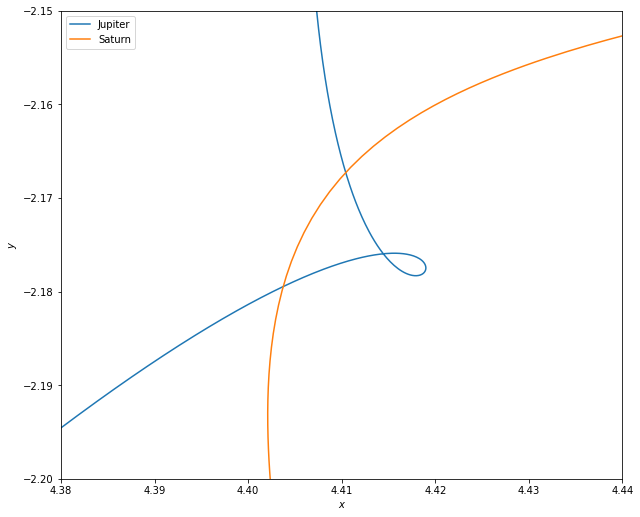

In [13]:
out_ce = out_ce.reshape((-1, 5, 6))
fig = plt.figure(figsize=(9, 9))

ax = plt.subplot(111)

ax.set_aspect('equal')
ax.plot(out_ce[:, 1, 0], out_ce[:, 1, 1], label='Jupiter')
ax.plot(out_ce[:, 2, 0], out_ce[:, 2, 1], label='Saturn')
ax.set_xlim((4.38, 4.44))
ax.set_ylim((-2.20, -2.15))
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend()

plt.tight_layout()

We can see how Jupiter's motion becomes temporarily retrograde during the encounter with Saturn.

Note how the integrator automatically decreased the timestep size in correspondence of the close encounter:

In [14]:
print("Min. timestep: {}".format(min_h))
print("Max. timestep: {}".format(max_h))

Min. timestep: 0.00013865629022107346
Max. timestep: 0.124164535505792
